# 학종이만한 이미지를 사진만하게 늘리기

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [2]:
import imageio
x = imageio.imread('./dataset/training/00001.png')

In [3]:
x.shape

(800, 600, 3)

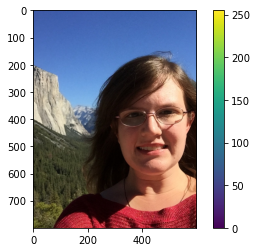

In [4]:
plt.imshow(x)
plt.colorbar()
plt.show()

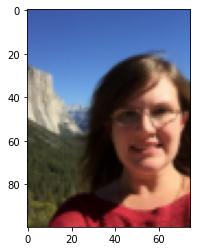

In [5]:
# x를 각각 (800, 600, 3) -> (100, 75, 3)로 줄이고 plt에서 확인하는 코드를 작성하세요.
from skimage.transform import resize

x1=resize(x,(100,75,3))
x1.shape

plt.imshow(x1)
plt.show()

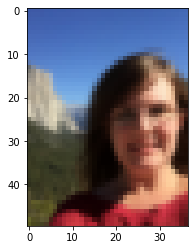

In [6]:
# x를 각각 (800, 600, 3) -> (50, 37, 3)로 줄이고 plt에서 확인하는 코드를 작성하세요.
x2=resize(x,(50,37,3))
x2.shape

plt.imshow(x2)
plt.show()

In [7]:
pfcn_small=np.load('./pfcn_small.npz')

In [8]:
list(pfcn_small.keys())

['train_images', 'test_images', 'train_mattes', 'test_mattes']

In [9]:
train_big_images = pfcn_small['train_images']
test_big_images = pfcn_small['test_images']

In [10]:
train_big_images.shape, test_big_images.shape

((1700, 100, 75, 3), (300, 100, 75, 3))

In [11]:
# train_big_images, test_big_images를 (50, 37, 3)으로 축소하고 
# train_small_images / test_small_images의 이름으로 할당하세요.

train_small_images = np.array([resize(img,(50,37,3)) for img in train_big_images ])
test_small_images = np.array([resize(img, (50,37,3)) for img in test_big_images])

In [12]:
train_small_images.shape,test_small_images.shape

((1700, 50, 37, 3), (300, 50, 37, 3))

In [13]:
train_big_images.dtype

dtype('float64')

# 전처리

In [14]:
print(train_big_images.max(), train_big_images.min())
print(test_big_images.max(),test_big_images.min())

1.0 0.0
1.0 0.0


In [15]:
# (배치, 100, 75, 3)인 train_big_images에서 (5, 100, 75, 3)을 획득하는 코드를 작성하세요.
train_big_images[:5].shape

(5, 100, 75, 3)

In [16]:
# 해당 기능을 이용해서 (100, 375, 3)을 작성하는 코드를 작성해보세요.
train_big_images[:5].transpose(1,0,2,3).reshape((100,375,3)).shape

(100, 375, 3)

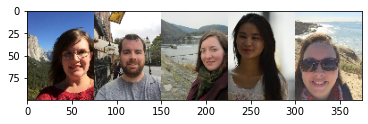

In [17]:
# (50, 37 * 5, 3)의 이미지를 plt로 출력해보세요.
plt.imshow(train_big_images[:5].transpose(1,0,2,3).reshape((100,-1,3)))
plt.show()

# U-Net Model

In [18]:
# input (50, 37, 3), output (100, 75, 3)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import MaxPool2D, BatchNormalization, Dropout, Activation, concatenate

In [19]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [20]:
def unet_resolution():
    inputs = Input((50, 37, 3))
    
    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)
    
    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)
    
    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)
    
    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)
    
    c5 = conv2d_block(p4, 256)
    
    u6 = Conv2DTranspose(128, 2, 2)(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    
    c6 = conv2d_block(u6, 128)
    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(0,1))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    
    c7 = conv2d_block(u7, 64)
    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(1,0))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)
    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)
    u10 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c9)
    outputs = Conv2D(3, 1, activation="sigmoid")(u10)
    model = Model(inputs, outputs)
    return model

In [21]:
model = unet_resolution()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 37, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 37, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50, 37, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 37, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
# 만든 모델에 loss는 mae, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(loss='mae',optimizer='adam',metrics='accuracy')

In [23]:
hist = model.fit(train_small_images, train_big_images, validation_data=(test_small_images, test_big_images), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 112s 2s/step - loss: 0.1616 - accuracy: 0.4347 - val_loss: 0.2074 - val_accuracy: 0.5659
Epoch 2/25
54/54 [==============================] - 1s 20ms/step - loss: 0.0788 - accuracy: 0.6792 - val_loss: 0.1899 - val_accuracy: 0.6988
Epoch 3/25
54/54 [==============================] - 1s 20ms/step - loss: 0.0663 - accuracy: 0.7618 - val_loss: 0.1786 - val_accuracy: 0.7213
Epoch 4/25
54/54 [==============================] - 1s 19ms/step - loss: 0.0615 - accuracy: 0.7737 - val_loss: 0.1533 - val_accuracy: 0.7399
Epoch 5/25
54/54 [==============================] - 1s 20ms/step - loss: 0.0604 - accuracy: 0.7823 - val_loss: 0.1161 - val_accuracy: 0.7722
Epoch 6/25
54/54 [==============================] - 1s 20ms/step - loss: 0.0586 - accuracy: 0.7854 - val_loss: 0.1065 - val_accuracy: 0.7357
Epoch 7/25
54/54 [==============================] - 1s 19ms/step - loss: 0.0572 - accuracy: 0.7888 - val_loss: 0.0879 - val_accuracy: 0.7631
Epoch 8/25
54

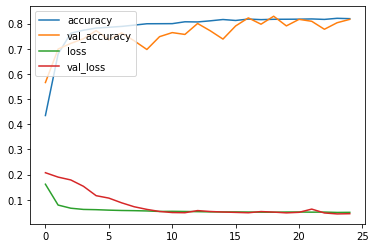

In [25]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [27]:
res = model.predict(test_small_images[1:2])

res.shape, test_small_images[:1].shape

((1, 100, 75, 3), (1, 50, 37, 3))

In [28]:
# test_small_images[1]을 resize 함수를 이용해여 (100, 75, 3) 으로 2배 확대하는 코드를 작성하세요.
exp = resize(test_small_images[1],(100,75))
exp.shape

(100, 75, 3)

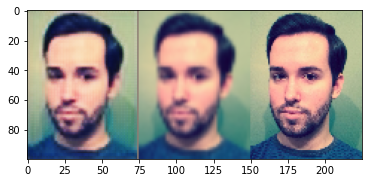

In [31]:
# res와 확대한 이미지, test_big_images[1]]를 width 방향으로 결합하여 
# (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.

imgs = np.concatenate([res[0],exp,test_big_images[1]], axis=1)
plt.imshow(imgs)
plt.show()

In [37]:
result = model.predict(test_small_images[:3])
exps = [resize(img, (100,75)) for img in test_small_images[:3]] # 사이즈 두배
imgs =np.concatenate([result,exps,test_big_images[:3]], axis=2).reshape((300,-1,3))

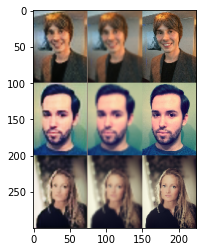

In [38]:
plt.imshow(imgs)

선명도를 올리는 연구도 활발함
CNN, GAN

In [39]:
infor = model.evaluate(test_small_images,test_big_images)

10/10 [==============================] - 0s 7ms/step - loss: 0.0445 - accuracy: 0.8169


In [40]:
model.save('./lec07.h5')

In [41]:
weight = tf.keras.models.load_model('./lec07.h5')

In [43]:
weight.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 37, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 37, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50, 37, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 37, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________